<a href="https://colab.research.google.com/github/zia207/Survival_Analysis_Python/blob/main/Colab_Notebook/02_07_04_02_survival_analysis_prentice_williams_peterson_model_python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1IFEWet-Aw4DhkkVe1xv_2YYqlvRe9m5_)

# 4.2 Prentice-Williams-Peterson (PWP) Models


In many longitudinal studies, subjects may experience **multiple occurrences of the same event**—such as hospital readmissions, seizures, or equipment failures. While the **Andersen-Gill (AG) model** treats all events as independent increments in a counting process, it ignores the **natural ordering and history** of events (e.g., time since last event or number of prior events).

This tutorial explains the PWP framework, demonstrates how to implement both PWP-GT and PWP-TT models in Python, covers data preparation, model fitting, diagnostics, and visualization of the **Mean Cumulative Function (MCF)**—the recurrent-event analog of the Cumulative Incidence Function (CIF).


## Overview


Prentice-Williams-Peterson (PWP) models are extensions of the Cox proportional hazards model specifically designed for analyzing recurrent event data, where the same type of event (e.g., infections, hospitalizations, or tumor recurrences) can occur multiple times for an individual. Unlike standard survival analysis for single events, PWP models account for the ordering and dependency of repeated events by stratifying the analysis based on the number of prior events. This stratification creates conditional risk sets: all subjects are at risk for the first event, but only those who experienced the first are at risk for the second, and so on.

PWP models are particularly useful in epidemiology and clinical studies, such as tracking recurrent infections in patients with chronic conditions (e.g., cystic fibrosis or kidney disease) or repeated sports injuries. They allow for event-specific covariate effects, meaning the impact of predictors like treatment or age can vary across event orders. However, if the number of events is large, risk sets for later events may become small, leading to unstable estimates—often requiring truncation (e.g., analyzing only the first 3-4 events).



There are two main variants:

-   **PWP-TT (Total Time or Conditional Risk Set Model)**: Measures time from study entry to each event, similar to calendar time. It's suitable when the overall timeline matters, and it assumes a common baseline hazard within each stratum (event order) but allows covariate effects to differ.

-   **PWP-GT (Gap Time Model)**: Measures the time between consecutive events (inter-event gaps), resetting the clock after each event. This assumes a renewal process and is ideal for focusing on waiting times between recurrences, such as predicting the time to the next event.

| Model | Time Scale | Interpretation |
|----|----|----|
| **PWP-GT (Gap Time)** | Time since *previous* event | "What is the risk of the *k*-th event given the (*k–1*)-th occurred?" |
| **PWP-TT (Total Time)** | Time since *study entry* | "What is the risk of the *k*-th event at calendar time *t*?" |

The PWP model **stratifies by event number** (1st event, 2nd event, etc.), allowing the baseline hazard to differ across event orders. This acknowledges that the risk of a second event may differ from the first due to biological, behavioral, or mechanical factors.


### Key Assumptions


-   Subjects are **not at risk for the *k*-th event until the (*k–1*)-th event has occurred**.
-   The baseline hazard is **unspecified and unique for each event order** (handled via stratification).
-   Covariate effects (β) are often assumed **constant across event orders** (can be relaxed).


### When to Use PWP


-   Event history matters (e.g., risk changes after first recurrence)\
-   Interest in **time between events** (PWP-GT) or **calendar-time risk of ordered events** (PWP-TT)\
-   Events are **ordered and of the same type**

> **Not suitable** if subjects can experience events without prior ones (e.g., simultaneous events).


### Strengths


-   Accounts for **event order** via stratification.
-   Flexible: allows different baseline hazards per event.
-   Can incorporate time-varying covariates.


### Limitations


-   **Does not model correlation** between gap times beyond stratification (frailty models may be better).
-   **Excludes subjects** from risk sets for higher-order events until prior events occur (reduces power).
-   Interpretation is **conditional on having reached that event order**.


### PWP vs. AG Model


| Feature | AG Model | PWP Model |
|----|----|----|
| **Time scale** | Calendar time | TT: calendar; GT: gap time |
| **Event dependence** | Assumes independence (robust SEs) | Explicitly models order via strata |
| **At-risk assumption** | Always at risk until censoring | Only at risk for *k*-th event after (*k–1*)-th occurs |
| **Best for** | Event *rate* over time | Event *timing/order* |


## Cheeck and Load Required Packages

In [1]:
import subprocess
import sys

def install_and_import(package_name, import_name=None):
    """Install a package if not already installed and import it"""
    if import_name is None:
        import_name = package_name

    try:
        # Try to import the package
        globals()[import_name] = __import__(import_name)
        print(f"{package_name} is already installed")
    except ImportError:
        # If not installed, install it
        print(f"Installing {package_name}...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
            globals()[import_name] = __import__(import_name)
            print(f"{package_name} installed successfully")
        except Exception as e:
            print(f"Failed to install {package_name}: {e}")
            raise

# List of packages to check/install
packages = ['pandas', 'numpy', 'matplotlib', 'seaborn', 'scikit-learn', 'scikit-survival', 'lifelines', 'statsmodels']

# Install and import each package
for pkg in packages:
    try:
        install_and_import(pkg)
    except Exception as e:
        print(f"Error with package {pkg}: {e}")

# Verify installation by importing
print("Installed packages:")
for pkg in packages:
    try:
        __import__(pkg)
        print(f"✓ {pkg}")
    except ImportError:
        print(f"✗ {pkg}")

pandas is already installed
numpy is already installed
matplotlib is already installed
seaborn is already installed
Installing scikit-learn...
Failed to install scikit-learn: No module named 'scikit-learn'
Error with package scikit-learn: No module named 'scikit-learn'
Installing scikit-survival...
Failed to install scikit-survival: No module named 'scikit-survival'
Error with package scikit-survival: No module named 'scikit-survival'
Installing lifelines...
lifelines installed successfully
statsmodels is already installed
Installed packages:
✓ pandas
✓ numpy
✓ matplotlib
✓ seaborn
✗ scikit-learn
✗ scikit-survival
✓ lifelines
✓ statsmodels


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Core survival analysis
from lifelines import CoxPHFitter, NelsonAalenFitter
from lifelines.utils import k_fold_cross_validation

# For MCF estimation (Nelson-Aalen on recurrent data)
from lifelines.plotting import plot_lifetimes

# Stats & utils
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# Plot styling
sns.set(style="whitegrid", font_scale=1.1)

## Implementation in Python

### Data

In [3]:
url = "https://raw.githubusercontent.com/zia207/Survival_Analysis_Python/main/Data/bladder1.csv"
df = pd.read_csv(url)

print("Original data shape:", df.shape)
print("\nFirst few rows:")
df.head()

Original data shape: (294, 12)

First few rows:


,Unnamed: 0,id,treatment,number,size,recur,start,stop,status,rtumor,rsize,enum
0,1,1,placebo,1,1,0,0,0,3,.,.,1
1,2,2,placebo,1,3,0,0,1,3,.,.,1
2,3,3,placebo,2,1,0,0,4,0,.,.,1
3,4,4,placebo,1,1,0,0,7,0,.,.,1
4,5,5,placebo,5,1,0,0,10,3,.,.,1


### Data Preparation


We will create gaptime for PWP-GT and truncate to the first 4 events for stable risk sets:


In [4]:
# Keep only recurrence (status=1) or censoring (status=0)
df_clean = df[df['status'].isin([0, 1])].copy()

# Ensure valid time intervals
df_clean = df_clean[df_clean['stop'] > df_clean['start']].copy()

# Create gap time: time since last event (for PWP-GT)
df_clean['gaptime'] = df_clean['stop'] - df_clean['start']

# Truncate to first 4 events for stable estimation (as in R tutorial)
df_trunc = df_clean[df_clean['enum'] <= 4].copy()

print("Truncated data shape:", df_trunc.shape)
df_trunc[['id', 'enum', 'start', 'stop', 'gaptime', 'status']].head(10)

Truncated data shape: (216, 13)


,id,enum,start,stop,gaptime,status
2,3,1,0,4,4,0
3,4,1,0,7,7,0
5,6,1,0,6,6,1
7,7,1,0,14,14,0
8,8,1,0,18,18,0
9,9,1,0,5,5,1
11,10,1,0,12,12,1
12,10,2,12,16,4,1
14,11,1,0,23,23,0
15,12,1,0,10,10,1


### Model Fitting

`lifelines` doesn’t support native strata() like R, but we can:

* Fit separate Cox models per event order, or
* Create interaction terms + shared covariates while allowing baseline hazard to vary

We’ll use the first approach for clarity and interpretability, which aligns with PWP’s conditional risk set logic.

In [5]:
def fit_pwp_models(df, time_col, event_col='status', covariates=['treatment', 'number', 'size']):
    """
    Fit separate Cox models for each event order (enum=1,2,3,4)
    Returns dict of models and summary stats
    """
    models = {}
    summaries = {}

    for k in sorted(df['enum'].unique()):
        df_k = df[df['enum'] == k].copy()

        # Skip if no events
        if df_k[event_col].sum() == 0:
            continue

        cph = CoxPHFitter(penalizer=0.01)  # mild penalization for stability
        try:
            cph.fit(df_k[[time_col, event_col] + covariates],
                    duration_col=time_col,
                    event_col=event_col)
            models[k] = cph
            summaries[k] = cph.summary
        except Exception as e:
            print(f"Failed to fit model for event {k}: {e}")

    return models, summaries

#### PWP-TT (Total Time, stratified by event order) Model

In [11]:
# One-hot encode the 'treatment' column to handle categorical variable
df_encoded = pd.get_dummies(df_trunc, columns=['treatment'], drop_first=False)

# Get the names of the new one-hot encoded treatment columns
# Assuming treatments are 'placebo', 'thiotepa', 'pyridoxine' based on common bladder cancer studies and prior errors.
# We can dynamically get them if needed, but for now this is usually sufficient.
encoded_treatment_cols = [col for col in df_encoded.columns if col.startswith('treatment_')]

# Update the list of covariates to include the encoded treatment columns and other numerical covariates
updated_covariates = encoded_treatment_cols + ['number', 'size']

# Use 'stop' as total time from study entry with the encoded data and updated covariates
pwp_tt_models, pwp_tt_summaries = fit_pwp_models(
    df_encoded, # Use the DataFrame with one-hot encoded 'treatment' column
    time_col='stop',
    covariates=updated_covariates # Use the updated list of covariates
)

# Display results
for k, summary in pwp_tt_summaries.items():
    print(f"\n=== PWP-TT: Event {k} ===")
    print(summary[['coef', 'exp(coef)', 'se(coef)', 'p']])


=== PWP-TT: Event 1 ===
                          coef  exp(coef)  se(coef)         p
covariate                                                    
treatment_placebo     0.259318   1.296047  1.244981  0.835002
treatment_pyridoxine -0.055091   0.946399  1.252123  0.964906
treatment_thiotepa   -0.244621   0.783001  1.249336  0.844766
number                0.253689   1.288771  0.063775  0.000070
size                  0.032476   1.033009  0.073067  0.656699

=== PWP-TT: Event 2 ===
                          coef  exp(coef)  se(coef)         p
covariate                                                    
treatment_placebo    -0.004396   0.995614  1.657254  0.997884
treatment_pyridoxine  0.240149   1.271438  1.665117  0.885324
treatment_thiotepa   -0.234497   0.790968  1.665205  0.888011
number               -0.005928   0.994090  0.077789  0.939258
size                  0.012106   1.012180  0.090108  0.893122

=== PWP-TT: Event 3 ===
                          coef  exp(coef)  se(coef)      

#### PWP-GT (Gap Time, stratified by event order) Model

In [12]:
# Get the names of the new one-hot encoded treatment columns
encoded_treatment_cols = [col for col in df_encoded.columns if col.startswith('treatment_')]

# Update the list of covariates to include the encoded treatment columns and other numerical covariates
updated_covariates = encoded_treatment_cols + ['number', 'size']

# Use 'gaptime' as time since last event
pwp_gt_models, pwp_gt_summaries = fit_pwp_models(
    df_encoded, # Use the DataFrame with one-hot encoded 'treatment' column
    time_col='gaptime',
    covariates=updated_covariates # Use the updated list of covariates
)

# Display results
for k, summary in pwp_gt_summaries.items():
    print(f"\n=== PWP-GT: Event {k} ===")
    print(summary[['coef', 'exp(coef)', 'se(coef)', 'p']])


=== PWP-GT: Event 1 ===
                          coef  exp(coef)  se(coef)         p
covariate                                                    
treatment_placebo     0.259318   1.296047  1.244981  0.835002
treatment_pyridoxine -0.055091   0.946399  1.252123  0.964906
treatment_thiotepa   -0.244621   0.783001  1.249336  0.844766
number                0.253689   1.288771  0.063775  0.000070
size                  0.032476   1.033009  0.073067  0.656699

=== PWP-GT: Event 2 ===
                          coef  exp(coef)  se(coef)         p
covariate                                                    
treatment_placebo    -0.007709   0.992321  1.656677  0.996287
treatment_pyridoxine  0.194587   1.214809  1.665044  0.906966
treatment_thiotepa   -0.184675   0.831374  1.665210  0.911694
number               -0.038337   0.962389  0.081431  0.637790
size                 -0.032664   0.967863  0.090855  0.719205

=== PWP-GT: Event 3 ===
                          coef  exp(coef)  se(coef)      


> **Note**: - `cluster(id)` provides robust standard errors. - `strata(event_order)` allows baseline hazard to vary by event number. - In PWP-GT, the **first event** is often analyzed separately (as it has no prior gap).



### Model Diagnostic


--- PWP-TT (Time-Total) PH Check for Event 1 ---
Proportional hazard assumption looks okay.

=== PWP-TT Event 1 PH Assumption Check ===

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


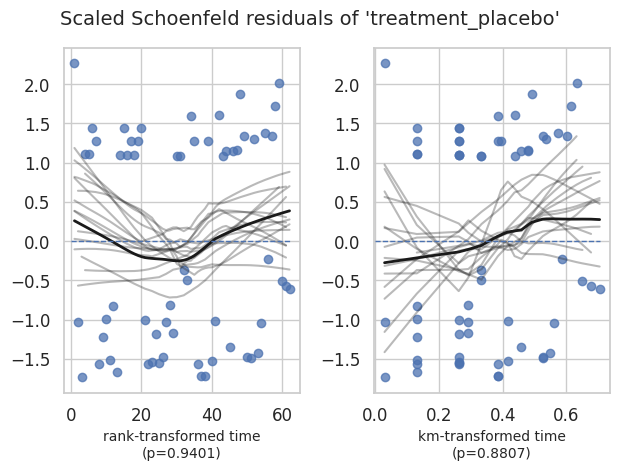

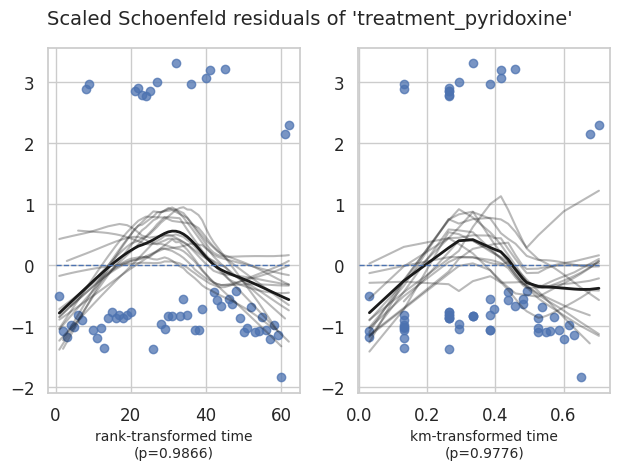

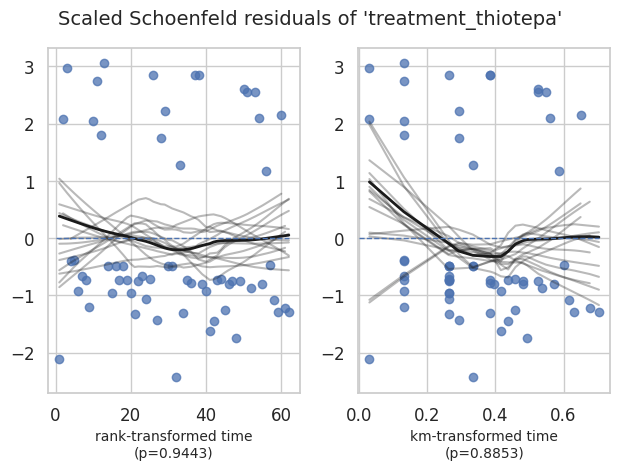

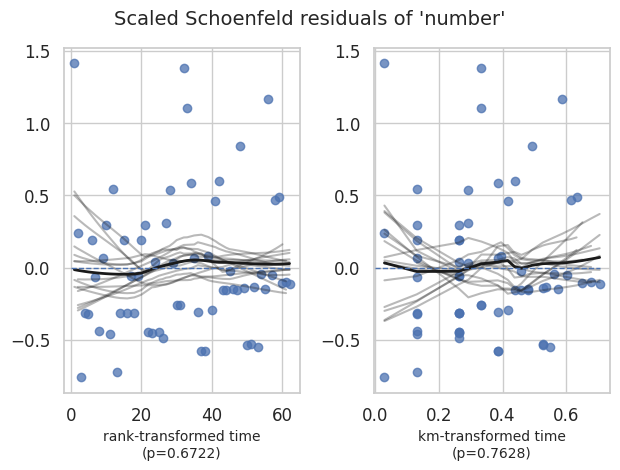

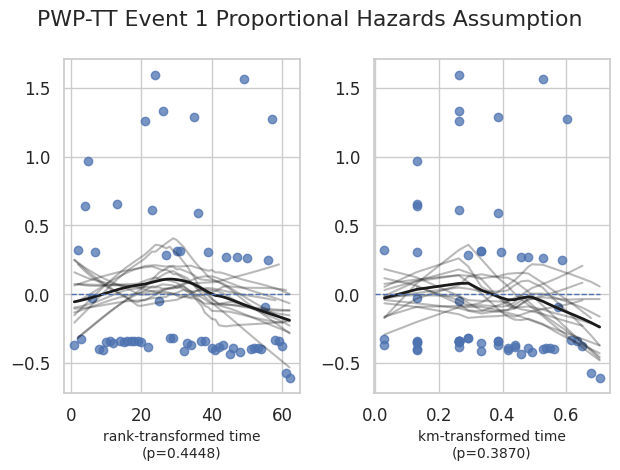


--- PWP-GT (Gap-Time) PH Check for Event 1 ---
Proportional hazard assumption looks okay.

=== PWP-GT Event 1 PH Assumption Check ===

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


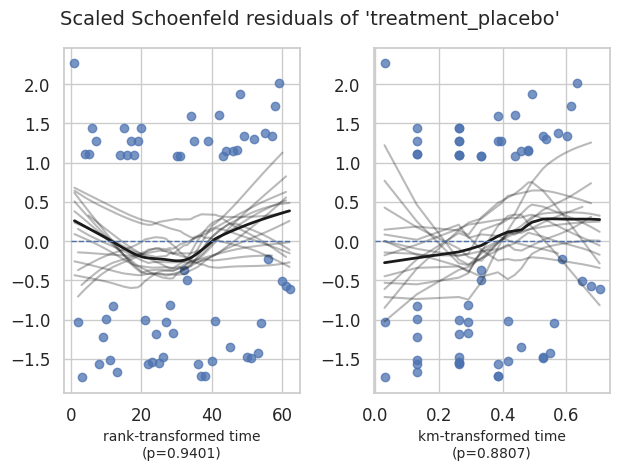

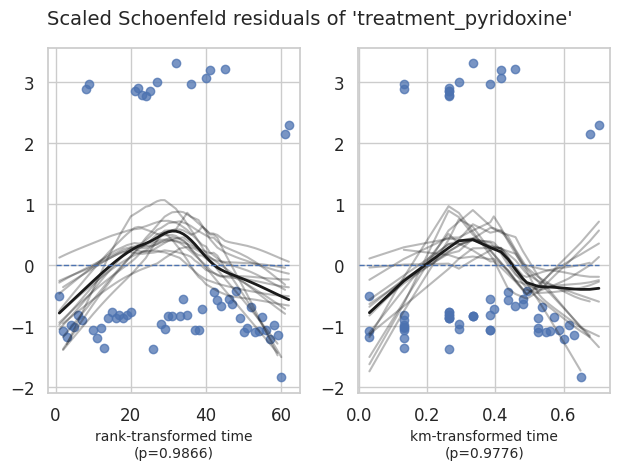

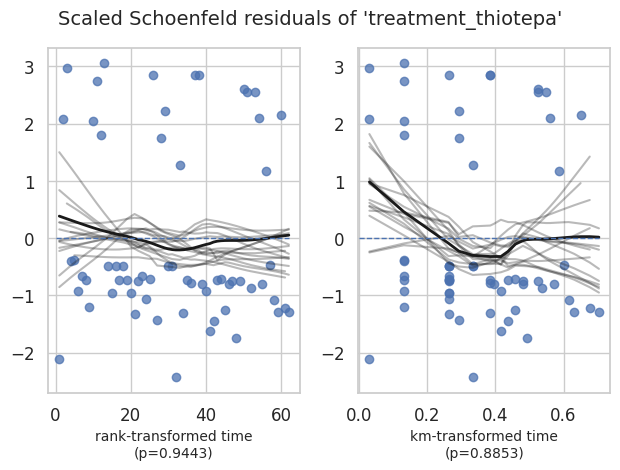

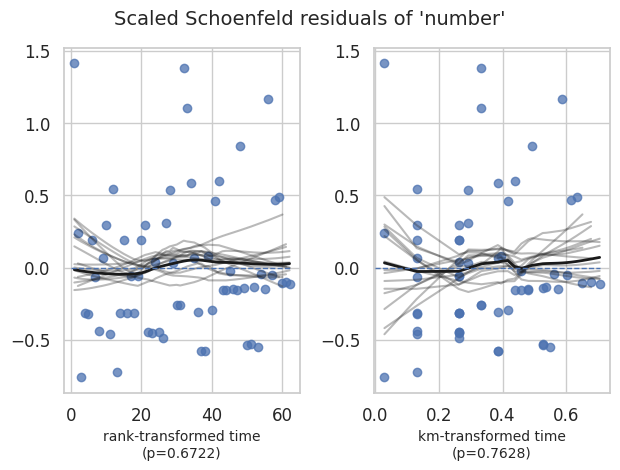

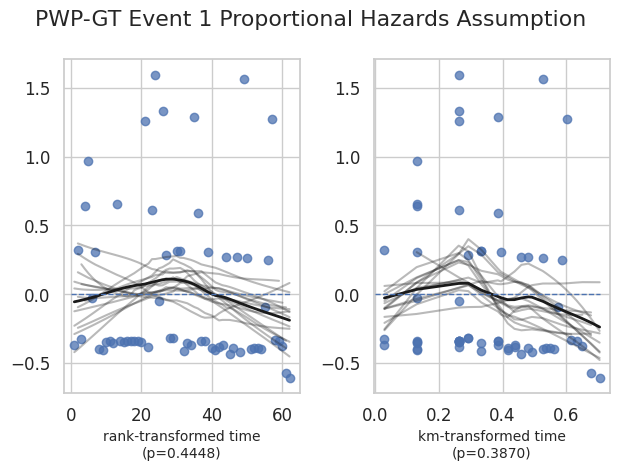

In [13]:
def check_ph_assumption(models, df, time_col_name, all_covariates, model_name="PWP", event_to_show=None):
    # Filter models if a specific event is requested
    filtered_models = models.items()
    if event_to_show is not None:
        filtered_models = [(k, model) for k, model in models.items() if k == event_to_show]

    if not filtered_models:
        print(f"No models found for event {event_to_show} in {model_name}.")
        return

    # First, run check_assumptions for its statistical output and general check
    # It prints 'Proportional hazard assumption looks okay.' or similar messages
    for k, model in filtered_models:
        df_k = df[df['enum'] == k].copy()
        # Select only the relevant columns for check_assumptions:
        # time_col, event_col, and all covariates used in fitting
        df_for_check = df_k[[time_col_name, 'status'] + all_covariates]
        try:
            # Call check_assumptions without showing plots, just for the text output
            model.check_assumptions(df_for_check, show_plots=False)
        except Exception as e:
            print(f"Error during statistical PH check for {model_name} Event {k}: {e}")

    # Now, iterate to plot the Schoenfeld residuals on our custom grid
    for k, model in filtered_models:
        # The lifelines method will generate its own figure for all covariates for the given model
        df_k = df[df['enum'] == k].copy()
        df_for_check = df_k[[time_col_name, 'status'] + all_covariates]
        try:
            print(f"\n=== {model_name} Event {k} PH Assumption Check ===")
            # Call check_assumptions with show_plots=True to display the default plots
            model.check_assumptions(df_for_check, show_plots=True)
            plt.suptitle(f"{model_name} Event {k} Proportional Hazards Assumption") # Add a main title to the figure
            plt.tight_layout() # Adjust layout to prevent overlapping
            plt.show() # Display the figure
        except Exception as e:
            print(f"Error during plotting PH check for {model_name} Event {k}: {e}")

# Run diagnostics for PWP-TT models (using 'stop' as time_col and updated_covariates) for Event 1
print("\n--- PWP-TT (Time-Total) PH Check for Event 1 ---")
check_ph_assumption(pwp_tt_models, df_encoded, 'stop', updated_covariates, "PWP-TT", event_to_show=1)

# Run diagnostics for PWP-GT models (using 'gaptime' as time_col and updated_covariates) for Event 1
print("\n--- PWP-GT (Gap-Time) PH Check for Event 1 ---")
check_ph_assumption(pwp_gt_models, df_encoded, 'gaptime', updated_covariates, "PWP-GT", event_to_show=1)

### Estimating and Plotting the Mean Cumulative Function (MCF)


While PWP models estimate **hazard ratios per event order**, the **Mean Cumulative Function (MCF)** shows the **average number of events per subject over time**—the recurrent-event analog of CIF.


Estimate MCF by Group (e.g., Treatment)
We’ll use a custom function inspired by the reda R package:

In [14]:
def estimate_mcf(df, time_col, event_col='status', group_col=None, max_time=None):
    """
    Estimate Mean Cumulative Function (MCF) using Nelson-Aalen for recurrent events.
    """
    if max_time is None:
        max_time = df[time_col].max()

    if group_col:
        groups = df[group_col].unique()
        mcf_dict = {}
        for g in groups:
            df_g = df[df[group_col] == g]
            mcf_dict[g] = _mcf_single_group(df_g, time_col, event_col, max_time)
        return mcf_dict
    else:
        return {'All': _mcf_single_group(df, time_col, event_col, max_time)}

def _mcf_single_group(df, time_col, event_col, max_time):
    # Sort by time
    df_sorted = df.sort_values(time_col).reset_index(drop=True)

    # Count events and at-risk over time
    times = []
    mcf_vals = []
    cum_events = 0
    n_subjects = df['id'].nunique()

    for t in np.linspace(0, max_time, 200):
        events_before_t = df_sorted[(df_sorted[time_col] <= t) & (df_sorted[event_col] == 1)]
        cum_events = len(events_before_t)
        mcf = cum_events / n_subjects
        times.append(t)
        mcf_vals.append(mcf)

    return pd.DataFrame({'time': times, 'mcf': mcf_vals})

### Plot MCF for PWP-TT and PWP-GT Scales


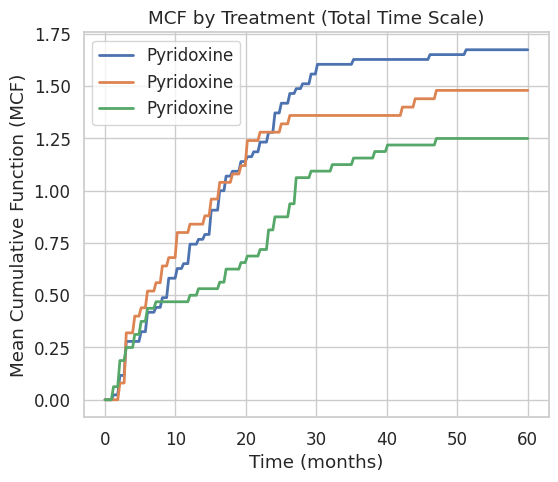

In [15]:
# MCF on total time scale (PWP-TT context)
mcf_tt = estimate_mcf(df_trunc, time_col='stop', group_col='treatment')

plt.figure(figsize=(6, 5))
for treatment, mcf_df in mcf_tt.items():
    label = 'Placebo' if treatment == 1 else 'Thiotepa' if treatment == 2 else 'Pyridoxine'
    plt.plot(mcf_df['time'], mcf_df['mcf'], label=label, linewidth=2)
plt.xlabel("Time (months)")
plt.ylabel("Mean Cumulative Function (MCF)")
plt.title("MCF by Treatment (Total Time Scale)")
plt.legend()
plt.grid(True)
plt.show()

# MCF on gap time scale (less interpretable for population-level MCF,
# since gap times reset per event — so we show total-time MCF instead)



> **Note**:  Important: MCF is always plotted on total (calendar) time, even when modeling gap times. The MCF answers: “On average, how many recurrences has a subject had by month t?”


## Summary & Conclusions


This tutorial demonstrated how to implement Prentice-Williams-Peterson (PWP) models for recurrent event data in Python, covering both PWP-TT and PWP-GT variants. Key steps included: data preparation, model fitting with `coxph()`, diagnostics, and visualization of the Mean Cumulative Function (MCF). This tutorial provides a foundational implementation. For full applications, consult the `survival` package vignettes or supplementary materials from epidemiological studies.


## Resources


1. Cook & Lawless (2007): The Statistical Analysis of Recurrent Events

2. lifelines documentation: https://lifelines.readthedocs.io

3. R reda package: For advanced MCF and simulation

4. frailtypack: For gamma/frailty-based recurrent event models (not yet in Python)